# Create BB84 Alogorithm

In [25]:
import numpy as np 
import qiskit_ibm_runtime as ibmruntime
import qiskit_aer as aer
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt
from qiskit.primitives import BackendSamplerV2 as Sampler
from qiskit.visualization import plot_histogram, plot_state_city
from qiskit import QuantumCircuit , transpile
from qiskit_ibm_runtime import SamplerOptions
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# ============================================================================================================
np.random.seed(None)

# Alice's Encoding Message

In [51]:
# create message 
def create_massage (message_length : int):
    # np.random.seed(None)
    message_list = np.random.randint(0,2,size = message_length)
    return message_list

Test Code: [0 1 0 0 1]
Test Basis: [1 0 1 0 0]


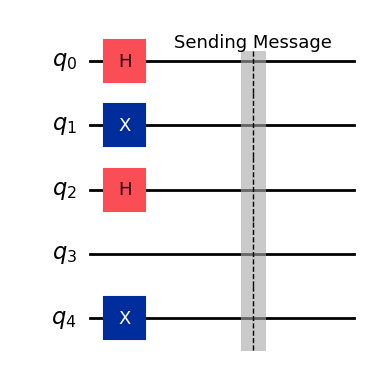

In [52]:
# encod message in a randomly chosen basis

def encoded_message(message_length : int,message_list):
    random_basis_list = np.random.randint(0 , 2 , size = message_length) # 0 : Z basis 1 : X basis
    encoded_quantum_circuit  = QuantumCircuit(message_length)
    
    for message , basis , bits in zip(message_list , random_basis_list, np.arange(message_length)):
        if basis == 0 and message == 0:
            pass
        elif basis == 0 and message == 1 :
            encoded_quantum_circuit.x(bits)
        elif basis == 1 and message == 0 :
            encoded_quantum_circuit.h(bits)
        elif basis == 1 and message == 1 :
            encoded_quantum_circuit.x(bits)
            encoded_quantum_circuit.h(bits)
            
    encoded_quantum_circuit.barrier(label= 'Sending Message')
    
    return encoded_quantum_circuit, random_basis_list

test_message_length = 5 
test_message = create_massage(test_message_length)
QC_test,basis_test = encoded_message(test_message_length,test_message)

print ("Test Code: {}\nTest Basis: {}".format(test_message,basis_test))
QC_test.draw('mpl')

        

# Bob's Measurement

# Looking for Correlations

Measured Basis: [0 1 1 1 0]


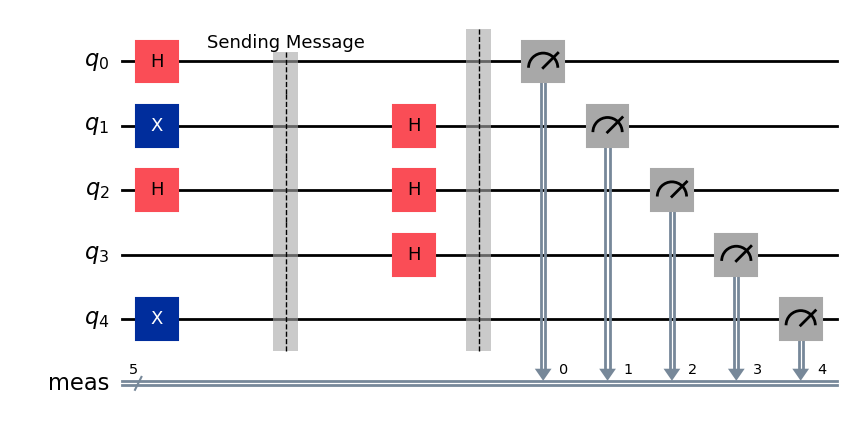

In [53]:
# Mesure the qubits through randomly choose basis
# 0 : Z basis 
# 1 : X basis

def create_measure_basis(message_length : int):
    random_measure_basis = np.random.randint(message_length)
    return random_measure_basis

def do_mesurement(message_length : int , measure_basis_list , message_quantum_circuit : QuantumCircuit):
    for basis , bits in zip(measure_basis_list , np.arange(message_length)) :
        if basis == 0 :
            pass
        elif basis == 1 :
            message_quantum_circuit.h(bits)
    # message_quantum_circuit.barrier(label= 'Measurement')
    message_quantum_circuit.measure_all()
    return message_quantum_circuit

test_measure_basis = create_massage(test_message_length)
print ("Measured Basis: {}".format(test_measure_basis))
measurement_quantum_circuit = do_mesurement(test_message_length, test_measure_basis ,QC_test)
measurement_quantum_circuit.draw('mpl')



# Run on Classical Simulator

151
<class 'qiskit.result.counts.Counts'>
Initial Basis: [1 0 1 0 0]
Measured Basis: [0 1 1 1 0]
Share the same basis: [0, 0, 1, 0, 1]


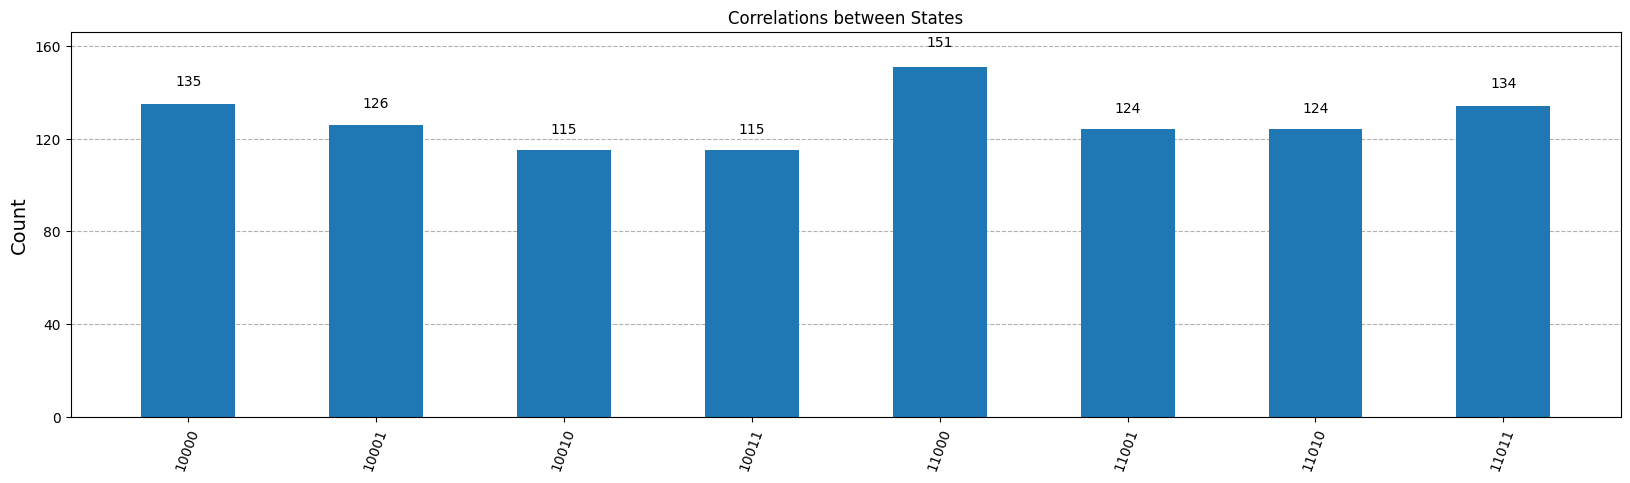

In [58]:
# find if there is any correlations between states (on simulators)
simulator = aer.AerSimulator()
transpiled_circuit = transpile(measurement_quantum_circuit,simulator)

result = simulator.run(transpiled_circuit).result()
counts = result.get_counts(transpiled_circuit)

print ("Initial Basis: {}".format(basis_test))
print ("Measured Basis: {}".format(test_measure_basis))
print ("Share the same basis: {}".format([(not (basis_test[i]^test_measure_basis[i]))*1 for i in range(test_message_length)]))
plot_histogram(counts, title='Correlations between States',figsize=(20,5))

In [88]:
plot_histogram({'123':100,'111':50},title='test')
print(type('1'))
a=str("1234")
print(a[2])


<class 'str'>
3
{'233': 43}


[0, 0, 1, 0, 1]
('11', [0, 4])
151
{'10010': 115, '11010': 124, '11000': 151, '11001': 124, '11011': 134, '10000': 135, '10001': 126, '10011': 115}
[0, 0, 1, 0, 1] dict_keys(['10010', '11010', '11000', '11001', '11011', '10000', '10001', '10011'])


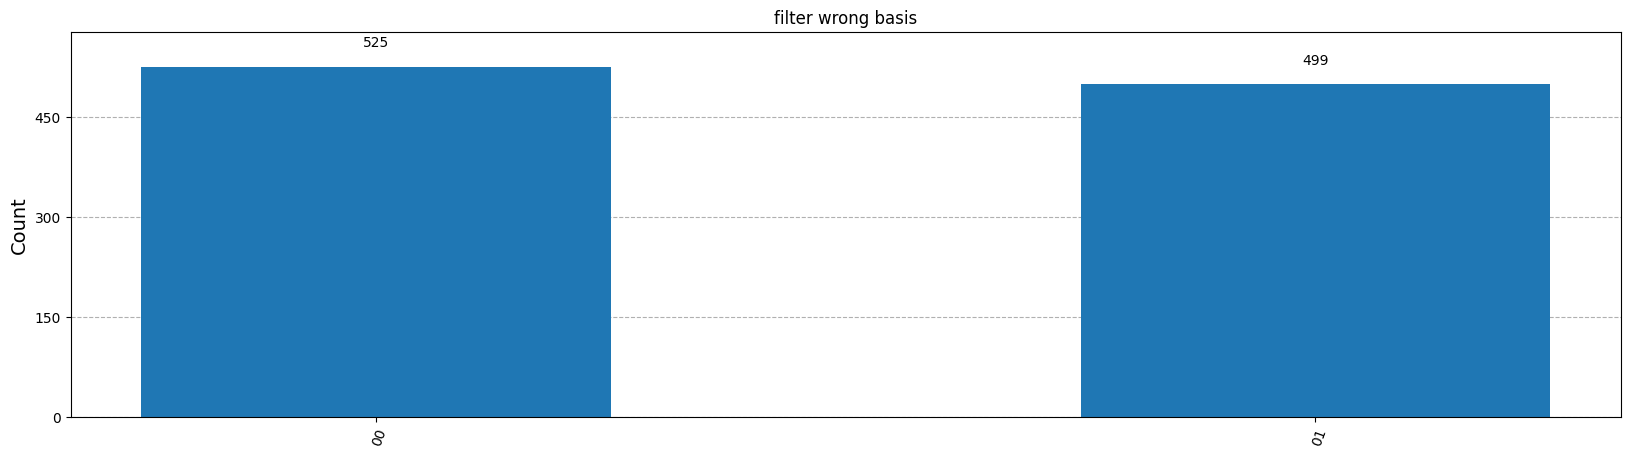

In [98]:
# Test block
def share_basis(basis_test,test_measure_basis):
    test_message_length = len(test_measure_basis)
    return [(not (basis_test[i]^test_measure_basis[i]))*1 for i in range(test_message_length)]

samebasis_list = share_basis(basis_test, test_measure_basis)
print(samebasis_list)

def basis_filter(qubits, samebasis_list):
    if (len(qubits) != len(samebasis_list)): 
        raise Exception("cannot filter the basis")
        
    filter_qubits = ''
    index = []
    for i in range(len(qubits)):
        if (bool(samebasis_list[i])): 
            filter_qubits+=str(qubits[i])
            index.append(i)
    return filter_qubits, index

print(basis_filter('11011',[1,0,0,0,1]))

def basis_matched(samebasis_list, counts):
    if (len(samebasis_list) != len(next(iter(counts.keys())))):
        raise Exception("qubit numbers are not the same in data")
    
    update_state = {}
    for state in counts.keys():
        new_key, index = basis_filter(state,samebasis_list)
        if (new_key in update_state.keys()): update_state[new_key] += counts[state]
        else: update_state[new_key] = counts[state]
        
    return update_state
    
counts = result.get_counts(transpiled_circuit)

print(dict(counts))
print(samebasis_list, counts.keys())
filter_states = basis_matched(samebasis_list, counts)
plot_histogram(filter_states, title='filter wrong basis',figsize=(20,5))

# Run on IBM Quantum Hardware

In [99]:
# finding correlations on IBM quantum computers
backend_name = 'ibm_kyiv'
backend      = QiskitRuntimeService().backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level = 1, backend = backend)
transpiled_circuit_quantum = pass_manager.run(measurement_quantum_circuit)




In [100]:
quantum_sampler_1_options = SamplerOptions()
quantum_simulator_1 = Sampler(backend=backend)
job = quantum_simulator_1.run([transpiled_circuit_quantum])
job_id = job.job_id()
print(job_id)

7264d261-afab-430b-9626-55258897a647
